from IPython.parallel import Client
IP_client = Client()
IP_view = IP_client.load_balanced_view()

In [ ]:
# Import 
%run header.ipynb
%run datascience.ipynb
%run D1A.ipynb
%matplotlib inline

import shutil
from bs4 import BeautifulSoup

from pyedgar.utilities import plaintext
from pyedgar.utilities import forms
from pyedgar.utilities import edgarweb
from pyedgar.utilities import localstore
from pyedgar.utilities import htmlparse
from pyedgar.exceptions import *

In [ ]:
os.chdir(FEED_ROOT)

# Load 10-Q list

In [ ]:
ROOT = {c:os.path.join(DATA_ROOT, c+'1A') for c in 'K Q'.split()}
FORM = 'Q'
FILENAME_TMPLT = os.path.join(DATA_ROOT, 'blobs.{}.{:%Y-%m-%d}.csv')
FILENAME_TMP = lambda: FILENAME_TMPLT.format(FORM.lower(), dt.date.today())

In [3]:
tens = pd.read_csv(os.path.join(IDX_ROOT, 'form_10.periods.csv'))
for c in 'filedate period'.split():
    tens[c] = pd.to_datetime(tens[c])
tens = tens[tens.filedate >= dt.date(2005,1,1)].sort_values('cik filedate'.split()).reset_index(drop=True)
print(len(tens.cik), len(tens[tens.period.notnull()].cik), tens.filedate.max())
linkhead(tens, n=1)

369656 351967 2016-05-20 00:00:00


cik,name,form,filedate,accession,period,sic,ff12_name,ff12,ff48,ff48_name,links
20,K TRON INTERNATIONAL INC,10-K,2005-03-31,0000893220-05-000728,2005-01-01,3823,BusEq,6,37,LabEq,FTPHTML
20,K TRON INTERNATIONAL INC,10-Q,2005-05-05,0000893220-05-001038,2005-04-02,3823,BusEq,6,37,LabEq,FTPHTML
20,K TRON INTERNATIONAL INC,10-Q,2005-08-03,0000893220-05-001794,2005-07-02,3823,BusEq,6,37,LabEq,FTPHTML
20,K TRON INTERNATIONAL INC,10-Q,2005-10-31,0000893220-05-002440,2005-10-01,3823,BusEq,6,37,LabEq,FTPHTML
20,K TRON INTERNATIONAL INC,10-K,2006-03-23,0000893220-06-000650,2005-12-31,3823,BusEq,6,37,LabEq,FTPHTML


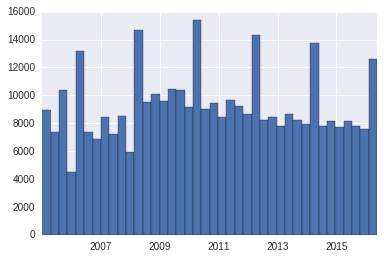

In [4]:
tens.filedate.hist(bins=40)

246885


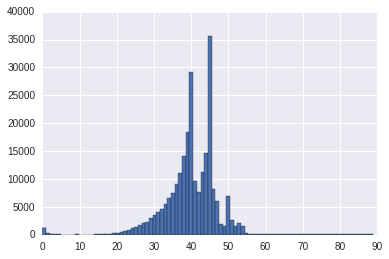

In [5]:
_ = tens[(tens.form.str.contains('Q'))
         &(tens.period <= tens.filedate) 
         &(abs((tens.period - tens.filedate)/TD_DAY)<90)]
print(len(_))
((_.filedate - _.period) / TD_DAY).hist(bins=90)

# Load 10-K/Q dataframes

In [ ]:
existing_files = [os.path.basename(f) for f in localstore.walk_files(ROOT[FORM])]
df_files = pd.DataFrame([x[:-5].split('_') + [x] for x in existing_files],
                        columns='cik fdate accession path'.split())
df_files['cik'] = df_files.cik.astype(int)
del df_files['fdate']
linkhead(df_files, n=1)

In [16]:
df = tens[tens.form.str.contains(FORM)].copy()
df = df.merge(pd.read_csv(os.path.join(DATA_ROOT, 'blobs.{}.csv'.format(FORM.lower())),
                          usecols='cik accession starts ends'.split()),
              on='cik accession'.split(), how='outer', suffixes=('', '_old'))
df = df.merge(df_files, on='cik accession'.split(), how='left')
df.ix[df.path.isnull(), 'starts ends'.split()] = np.nan
print("# of 10-Qs to search:", len(df))

if os.path.exists(os.path.join(DATA_ROOT, 'all_data_merge.csv')):
    _tmpdf = pd.read_csv(os.path.join(DATA_ROOT, 'all_data_merge.csv'),
                         usecols='gvkey cik permno num_headers atq mcap'.split())
    _sel = _tmpdf['gvkey cik permno'.split()].notnull().all(axis=1)
    _sel = _tmpdf[_sel].cik.unique()
    
    df = df[df.cik.isin(_sel)]
    print("# of filtered 10-Qs to search:", len(df))

linkhead(df[df.cik==1750], n=2)
tmp = len(tens[tens.cik.isin(_sel)]), len(df), sum(df.starts>0)
print("10s: {}\nQs:  {} ({:2.0f}%)\nFound: {} ({:2.0f}%)\nMissing: {} ({:2.0f}%)"
      .format(tmp[0], tmp[1], tmp[1]/tmp[0]*100, 
              tmp[2], tmp[2]/tmp[1]*100, tmp[1]-tmp[2], (tmp[1]-tmp[2])/tmp[1]*100))

# of 10-Qs to search: 267674
# of filtered 10-Qs to search: 158212


cik,name,form,filedate,accession,period,sic,ff12_name,ff12,ff48,ff48_name,starts,ends,links
1750,AAR CORP,10-Q,2005-01-05,0001104659-05-000400,2004-11-30,3720,Manuf,3,24,Aero,0,0,FTPHTML
1750,AAR CORP,10-Q,2005-04-06,0001104659-05-015316,2005-02-28,3720,Manuf,3,24,Aero,0,0,FTPHTML


10s: 369656
Qs:  158212 (43%)
Found: 98169 (62%)
Missing: 60043 (38%)


In [ ]:
existing_files = [os.path.basename(f) for f in localstore.walk_files('/data/D1A/Q1A/')]
df_files = pd.DataFrame([x[:-5].split('_') + [x] for x in existing_files],
                        columns='cik fdate accession path'.split())
df_files['cik'] = df_files.cik.astype(int)
del df_files['fdate']
linkhead(df_files)

# Iterate and search 10-Ks

In [17]:
# This searches through HTML, so include anything inside <>s as nothing
RE_item = re.compile('^(?:\s|</?[a-z][^>]*>|&nbsp;)*'
                     'item[^a-z0-9]*(\d+[\sAB]*)', re.I)

RE_1A = re.compile('^[^a-z0-9\r\n]*item[^a-z0-9]*1A[^a-z]*risk[^a-z]*factors?', re.I)
RE_next = re.compile('^[^a-z0-9\r\n]*item[^a-z0-9]*(1B|[2-90]+A?)', re.I)

In [18]:
RE_item = re.compile('^(?:\s|</?[a-z][^>]*>|&nbsp;)*'
                     'item[^a-z0-9]*(\d+[\sAB]*)', re.I)

RE_1A = re.compile('^[^a-z0-9]*item[^a-z0-9]*1A[^a-z]*risk[^a-z]*factors?\s*$', re.I)
RE_next = re.compile('^[^a-z0-9\r\n]*item[^a-z0-9]*(1B|[2-90]+A?)', re.I)

re_clean = lambda x: re.compile('[^a-z0-9]+', re.I).sub(' ', x)

In [19]:
EMPH_TAGS = "b strong h1 h2 h3 h4 h5 h6 u".split()
FACE_TAGS = "p font div span li".split()
EMPH_STYLE = re.compile(r"bold|underline", re.I)
DIVIDER_STYLES = 'h1 h2 h3 h4 h5 h6 p div ul ol tr table'.split()

In [20]:
def find_items(soup, debug=False):
    collect_1as = []
    collect_next = []
    for tag in soup.find_all(text=RE_item):
        for parent_tag in tag.parents:
            if parent_tag.name.lower() in EMPH_TAGS \
               or (parent_tag.name.lower() in FACE_TAGS
                   and EMPH_STYLE.search(parent_tag.attrs.get('style', ''))):
                if debug: print('Emphasized {!r}'.format(tag))
                # Then ITEM is emphasized. Break and skip the continue below.
                break
        else: continue

        temp_parent = None
        for parent_tag in tag.parents:
            if parent_tag.name.lower() in DIVIDER_STYLES:
                if debug: print('Container {} for {!r}'.format(parent_tag.name, tag))
                if temp_parent is None:
                    temp_parent = parent_tag
                elif parent_tag.name.lower() == 'tr':
                    # If item is in table, then search whole row.
                    trtxt = re_clean(parent_tag.get_text())
                    if debug: print('Found {} but found tr: {!r}'
                                    .format(temp_parent.name, trtxt))
                    if RE_1A.search(trtxt):
                        if debug: print('Found {} but matched 1A in tr {!r}'
                                        .format(temp_parent.name, trtxt))
                        temp_parent = parent_tag
                    break
            elif parent_tag.name.lower() == 'body':
                break
        parent_tag = temp_parent
        
        if parent_tag is None:
            if debug: print("Parent tag wasn't container of {!r}".format(tag))
            continue

        full_text = re_clean(parent_tag.get_text())
        if debug: print("Full text of {!r} is {!r}".format(tag, full_text))

        if RE_1A.search(full_text):
            collect_1as.append(parent_tag)
            parent_tag.insert_before(soup.new_tag('STARTHERE'))
            if debug: print("Inserted start before 1A: {}".format(str(parent_tag)[:50]))
        elif collect_1as and RE_next.search(full_text):
            collect_next.append(parent_tag)
            parent_tag.insert_after(soup.new_tag('ENDHERE'))
            if debug: print("Inserted end after {}".format(str(parent_tag)[:50]))
            break
    return collect_1as, collect_next

In [22]:
OUT_FPATTERN = os.path.join(DATA_ROOT, 'Q1A/{cik:010d}_{filedate:%Y-%m-%d}_{accession}.html')

In [24]:
df.head(1)

,cik,name,form,filedate,accession,period,sic,ff12_name,ff12,ff48,ff48_name,starts,ends
0,20,K TRON INTERNATIONAL INC,10-Q,2005-05-05,0000893220-05-001038,2005-04-02,3823,BusEq,6,37,LabEq,0,0


In [84]:
def res_to_df(results):
    _df = (pd.DataFrame.from_dict(results, orient='index')
              ['starts ends'.split()]
              .reset_index())
    _df['filename'] = _df['index'].apply(lambda x: x.split('/')[-1])
    _df['cik'] = _df['filename'].apply(lambda x: int(x.split('_')[0]))
    _df['accession'] = _df['filename'].apply(lambda x: x.split('_')[-1][:-5])
    return _df

In [27]:
BAD_STARTEND = [None,]*99
tmpdf = df[~(df.starts > 0)]
results = {}

## Main Loop

In [40]:
DEBUG = False

try:
    for i,row in tqdm(tmpdf.iterrows(), total=len(tmpdf)):
        src_fname = localstore.get_filing_path(row.cik, row.accession)
        if not os.path.exists(src_fname):
            continue
        
        dest_fname = OUT_FPATTERN.format(**row)

        if (os.path.exists(dest_fname)
            or dest_fname in results):
            continue
            
        results[dest_fname] = {}

        try:
            rtxt = forms.get_form(src_fname)
        except EDGARFilingFormatError:
            continue
        if not htmlparse.RE_HTML_TAGS.findall(rtxt, 0, 500):
            # Not HTML
            continue

        soup = BeautifulSoup(rtxt, 'lxml')

        starts, ends = find_items(soup)
        istart,iend = -1, -1

        if len(starts) >= 1 and len(ends) == 1:
            try:
                prtxt = str(soup)
            except RuntimeError:
                # Some forms are so bad that beautiful soup craps out. Handle that here.
                prtxt = ''
                starts, ends = BAD_STARTEND, BAD_STARTEND

            istart,iend = prtxt.find('<STARTHERE>'),prtxt.find('</ENDHERE>')

            if istart > 0 and iend > 0:
                onea = prtxt[istart:iend+len('</ENDHERE>')]

                with open(dest_fname, 'w') as fh:
                    fh.write(onea)
        
        results[dest_fname].update({'starts':len(starts), 'ends':len(ends)})
        if DEBUG and i > 20: break
finally:
    res_to_df(results).to_csv(FILENAME_TEMPLATE.format(dt.datetime.today())+'.scrape', index=False)

In [80]:
if "Add results to DataFrame":
    df_new = res_to_df(results)
    del df_new['index']

    df_new = df.merge(df_new, on='cik accession'.split(), how='outer', suffixes=('', '_new'))
    for c in 'starts ends'.split():
        df_new[c] = df_new[[c, c+'_new']].max(axis=1)
        del df_new[c+'_new']

if "Copy New Results to blobs (and backup old)":
    blob_fnam = os.path.join(DATA_ROOT, 'blobs.{}.csv'.format(FORM.lower()))

    if os.path.exists(blob_fnam):
        _t = dt.datetime.fromtimestamp(os.path.getmtime(blob_fnam))
        backup_fnam = os.path.join(DATA_ROOT, 
                                   'blobs.{}.{:%Y-%m-%d}.csv'.format(FORM.lower(), _t))
        if not os.path.exists(backup_fnam):
            shutil.copy2(blob_fnam, backup_fnam)

    (df_new['cik name form filedate accession period starts ends'.split()]
            .to_csv(FILENAME_TMP(), index=False))
    (df_new['cik name form filedate accession period starts ends'.split()]
            .to_csv(blob_fnam, index=False))

if "Summarize":
    tmp = len(tens), len(df_new), sum(df_new.starts>0)
    print("10s: {}\nKs:  {} ({:2.0f}%)\nFound: {} ({:2.0f}%)\nMissing: {} ({:2.0f}%)"
          .format(tmp[0], tmp[1], tmp[1]/tmp[0]*100, 
                  tmp[2], tmp[2]/tmp[1]*100, tmp[1]-tmp[2], (tmp[1]-tmp[2])/tmp[1]*100))
    linkhead(df_new, n=3)

,cik,name,form,filedate,accession,period,sic,ff12_name,ff12,ff48,ff48_name,starts,ends,filename
0,20,K TRON INTERNATIONAL INC,10-Q,2005-05-05,0000893220-05-001038,2005-04-02,3823,BusEq,6,37,LabEq,0,0,0000000020_2005-05-05_0000893220-05-001038.html


# Debugging one-runners

In [88]:
dest_fname

'/data/D1A/Q1A/0001660719_2016-05-10_0001558370-16-005753.html'

In [124]:
_ = 1005817, '0001019056-08-000614'
tmp = df[(df.cik == _[0]) & (df.accession == _[1])]
linkhead(tmp)
src_fname = localstore.get_filing_path(*_)
dest_fname = OUT_FPATTERN_Q.format(**tmp.iloc[0].to_dict())

print(src_fname)
print(dest_fname)

cik,name,form,filedate,accession,period,starts,ends,links
1005817,TOMPKINS FINANCIAL CORP,10-Q,2008-05-12,0001019056-08-000614,2008-03-31,,,FTPHTML


/data/storage/edgar/feeds/00/01/00/58/17/0001019056-08-000614.txt
/data/D1A/Q1A/0001005817_2008-05-12_0001019056-08-000614.html


In [125]:
rtxt = forms.get_form(src_fname)

In [126]:
txt = htmlparse.convert_html_to_text(rtxt)
len(rtxt), len(txt)

(597869, 159461)

In [127]:
soup = BeautifulSoup(rtxt, 'lxml')

In [161]:
RE_item = re.compile('^[^a-z0-9\r\n]*item[^a-z0-9]*(\d+[\sAB]*)', re.I)

RE_1A = re.compile('^[^a-z0-9]*item[^a-z0-9]*1A[^a-z]*risk[^a-z]*factors?\s*$', re.I)
RE_next = re.compile('^[^a-z0-9\r\n]*item[^a-z0-9]*(1B|[2-90]+A?)', re.I)

re_clean = lambda x: re.compile('[^a-z0-9]+', re.I).sub(' ', x)

In [123]:
for file in localstore.walk_files('/data/D1A/Q1A/'):
    with open(file) as fh:
        txt = fh.read()
    if not RE_1A.search(txt):
        print(file)
        break

/data/D1A/Q1A/0000073088_2015-04-23_0000073088-15-000081.html


In [ ]:
for tag in soup.find_all(text=RE_item):
    print(tag)
    emphasized_tag = False
    for pnum, parent_tag in enumerate(tag.parents):
        if pnum > 4: break
        print('\t-- ', str(parent_tag)[:50].replace('\n', '\\n'))
        if parent_tag.name.lower() in EMPH_TAGS:
            print('Emphasized {}'.format(tag))
            emphasized_tag = True
        elif (parent_tag.name.lower() in FACE_TAGS and
              EMPH_STYLE.search(parent_tag.attrs.get('style', ''))):
            print('Emphasized {}'.format(tag))
            emphasized_tag = True

        if emphasized_tag: # Bold. Stop searching parents.
            break

In [165]:
debug = True
if debug:
    collect_1as = []
    collect_next = []
    for tag in soup.find_all(text=RE_item):
        for parent_tag in tag.parents:
            if parent_tag.name.lower() in EMPH_TAGS \
               or (parent_tag.name.lower() in FACE_TAGS
                   and EMPH_STYLE.search(parent_tag.attrs.get('style', ''))):
                if debug: print('Emphasized {!r}'.format(tag))
                # Then ITEM is emphasized. Break and skip the continue below.
                break
        else: continue
                
        temp_parent = None
        for parent_tag in tag.parents:
            if parent_tag.name.lower() in DIVIDER_STYLES:
                if debug: print('Container {} for {!r}'.format(parent_tag.name, tag))
                if temp_parent is None:
                    temp_parent = parent_tag
                elif parent_tag.name.lower() == 'tr':
                    trtxt = re_clean(parent_tag.get_text())
                    if debug: print('Found {} but found tr: {!r}'
                                    .format(temp_parent.name, trtxt))
                    if RE_1A.search(trtxt):
                        if debug: print('Found {} but matched 1A in tr {!r}'
                                        .format(temp_parent.name, trtxt))
                        temp_parent = parent_tag
                    break
            elif parent_tag.name.lower() == 'body':
                break
        parent_tag = temp_parent
        
        if parent_tag is None:
            if debug: print("Parent tag wasn't container of {!r}".format(tag))
            continue

        full_text = parent_tag.get_text().strip()
        if debug: print("Full text of {!r} is {!r}".format(parent_tag.name, full_text))

        if RE_1A.search(full_text):
            collect_1as.append(parent_tag)
            parent_tag.insert_before(soup.new_tag('STARTHERE'))
            if debug: print("Inserted start before 1A: {}".format(str(parent_tag)[:50]))
        elif collect_1as and RE_next.search(full_text):
            collect_next.append(parent_tag)
            parent_tag.insert_after(soup.new_tag('ENDHERE'))
            if debug: print("Inserted end after {}".format(str(parent_tag)[:50]))
            break

Emphasized 'Item 1 -'
Container p for 'Item 1 -'
Container tr for 'Item 1 -'
Found p but found tr: ' Item 1 Financial Statements Unaudited '
Full text of 'p' is 'Item 1 -'
Emphasized 'Item 2 -'
Container p for 'Item 2 -'
Container tr for 'Item 2 -'
Found p but found tr: ' Item 2 Management s Discussion and Analysis of Financial Condition and Results of Operations 13 24 '
Full text of 'p' is 'Item 2 -'
Emphasized 'Item 3 -'
Container p for 'Item 3 -'
Container tr for 'Item 3 -'
Found p but found tr: ' Item 3 Quantitative and Qualitative Disclosures about Market Risk 25 '
Full text of 'p' is 'Item 3 -'
Emphasized 'Item 4 -'
Container p for 'Item 4 -'
Container tr for 'Item 4 -'
Found p but found tr: ' Item 4 Controls and Procedures 26 '
Full text of 'p' is 'Item 4 -'
Emphasized 'Item 1 \x96'
Container p for 'Item 1 \x96'
Container tr for 'Item 1 \x96'
Found p but found tr: ' Item 1 Legal Proceedings 27 '
Full text of 'p' is 'Item 1 \x96'
Emphasized 'Item 1A \x96 Risk Factors'
Container p

In [129]:
starts, ends = find_items(soup, debug=True)
len(starts), len(ends)

Emphasized 'Item 1 -'
Container p for 'Item 1 -'
Full text of 'Item 1 -' is 'Item 1 -'
Emphasized 'Item 2 -'
Container p for 'Item 2 -'
Full text of 'Item 2 -' is 'Item 2 -'
Emphasized 'Item 3 -'
Container p for 'Item 3 -'
Full text of 'Item 3 -' is 'Item 3 -'
Emphasized 'Item 4 -'
Container p for 'Item 4 -'
Full text of 'Item 4 -' is 'Item 4 -'
Emphasized 'Item 1 \x96'
Container p for 'Item 1 \x96'
Full text of 'Item 1 \x96' is 'Item 1 \x96'
Emphasized 'Item 1A \x96 Risk Factors'
Container p for 'Item 1A \x96 Risk Factors'
Full text of 'Item 1A \x96 Risk Factors' is 'Item 1A \x96 Risk Factors'
Emphasized 'Item 2 \x96'
Container p for 'Item 2 \x96'
Full text of 'Item 2 \x96' is 'Item 2 \x96'
Emphasized 'Item 3 -'
Container p for 'Item 3 -'
Full text of 'Item 3 -' is 'Item 3 -'
Emphasized 'Item 4 -'
Container p for 'Item 4 -'
Full text of 'Item 4 -' is 'Item 4 -'
Emphasized 'Item 5 -'
Container p for 'Item 5 -'
Full text of 'Item 5 -' is 'Item 5 -'
Emphasized 'Item 6 -'
Container p for 

(0, 0)

In [95]:
try:
    prtxt = str(soup)#.prettify()
    istart = prtxt.find('<STARTHERE>')
    iend = prtxt.find('</ENDHERE>', max(istart, 0))
except RuntimeError:
    starts, ends = [], []

In [96]:
if len(starts) >= 1 and len(ends) == 1 and istart > 0 and iend > 0:
    onea = prtxt[istart:iend+len('</ENDHERE>')]

In [97]:
istart, iend, onea

(15846,
 16600,
 '<STARTHERE></STARTHERE><STARTHERE></STARTHERE><STARTHERE></STARTHERE><p><font size="2"><b><a href="#A013">Item 1A \x96 Risk Factors</a></b></font></p>\n</td>\n<td valign="BOTTOM">\n<p><font size="1">\xa0</font></p>\n</td>\n<td valign="BOTTOM">\n<p style="MARGIN-LEFT:8.65PT"><font size="2"><b>27</b></font></p>\n</td>\n</tr>\n<tr>\n<td valign="TOP">\n<p><font size="1">\xa0</font></p>\n</td>\n<td valign="TOP">\n<p><font size="1">\xa0</font></p>\n</td>\n<td valign="TOP">\n<p><font size="1">\xa0</font></p>\n</td>\n<td valign="BOTTOM">\n<p><font size="1">\xa0</font></p>\n</td>\n<td valign="BOTTOM">\n<p><font size="1">\xa0</font></p>\n</td>\n</tr>\n<tr>\n<td valign="TOP">\n<p><font size="1">\xa0</font></p>\n</td>\n<td valign="TOP">\n<p><font size="2"><b><a href="#A014">Item 2 \x96</a></b></font></p><ENDHERE></ENDHERE>')

In [121]:
display_html(onea, raw=True)

Item 1A  Risk Factors 
 
 
   
 
 
 27 
 
 
 
 
   
 
 
   
 
 
   
 
 
   
 
 
   
 
 
 
 
   
 
 
 Item 2 

In [ ]:
STOP
writeout = True
log.setLevel(logging.ERROR)
#dfi = df_new[(df_new['1'].isnull() | (df_new['1'] == ''))]
dfi = df_new
#dfi = df_new[df_new.cik == 20]
tot_all_rows = len(dfi)
i = -1
print("Searching through {}...".format(tot_all_rows))
for idx,row in dfi.iterrows():
    i += 1
    if i % 1000 == 999:
        log.critical("Done with {:5d}/{} ({:5d} left, found {} so far)"\
                     .format(i, tot_all_rows, tot_all_rows - i, len(dfi[dfi.match_score > 0])))
        if writeout:
            df_new.to_csv(FILENAME_DEV, index=False)
    log.debug('-'*20, idx, row['name'], row['year'], '-'*20)
    
    txt = forms.get_plaintext(row.path)
    
    log.debug("Length of text: {}".format(len(txt)))
    
    if not txt:
        df_new.loc[idx,'delta'] = NO_FILE_FOUND
        df_new.loc[idx,'match_score'] = 0
        log.debug("No text found :( %r", df_new.loc[idx])  # this CIK isn't an int
        continue
    
    res = do_search2(txt, row)#, debug=None if debug else print)
    
    df_new.loc[idx,'delta'], df_new.loc[idx,'delta_pct'] = res['d'],res['dp']
    if res['order_str'] is not None:
        (df_new.loc[idx,'1'], df_new.loc[idx,'2'],
         df_new.loc[idx,'3'], df_new.loc[idx,'4']) = res['order_str']
        df_new.loc[idx,'match_score'] = res['match_score']

if writeout:
    df_new.to_csv(FILENAME_DEV, index=False)

print("Searched {} and found {}, missed {}%"
      .format(tot_all_rows, len(dfi[dfi.match_score > 0]), 100-100*len(dfi[dfi.match_score > 0])/tot_all_rows))